In [193]:
import numpy as np
import warnings
warnings.simplefilter('ignore')
import pandas as pd
%pylab inline

#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.regression import mean_squared_error
from sklearn.metrics import classification_report,r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score, train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression, LassoCV, Lasso 

Populating the interactive namespace from numpy and matplotlib


In [213]:
xls_file = pd.ExcelFile('retail_vol_ccy_w_rt.xlsx')
df = xls_file.parse('Total', index_col=['Date'])
df.head()

NotImplementedError: parse_dates keyword of read_excel is not implemented

In [197]:
df['f_dec'].value_counts()

0    95
1     8
Name: f_dec, dtype: int64

In [ ]:
#%config InlineBackend.figure_format = 'png' 
#sns.pairplot(
#    df[['']]);

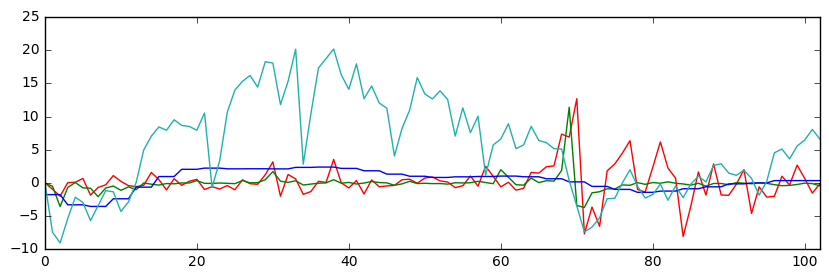

In [211]:
figsize(10, 3)
plt.plot(df['d_rubusd'] ,c = 'red')
plt.plot(df['d_rt3m'],c = 'green')
plt.plot(df['d_GPD']*50,c = 'blue')
plt.plot(df['portf_gr']*500,c = 'lightseagreen')
plt.xlim((0, 102))
plt.show()

In [169]:
predictors = list(set(['d_rubusd','d_rt3m','d_GPD','d_wage','f_jan','unp' ,'d_cpi']))#'wage',,'f_dec'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125405F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12CA3EB0>]], dtype=object)

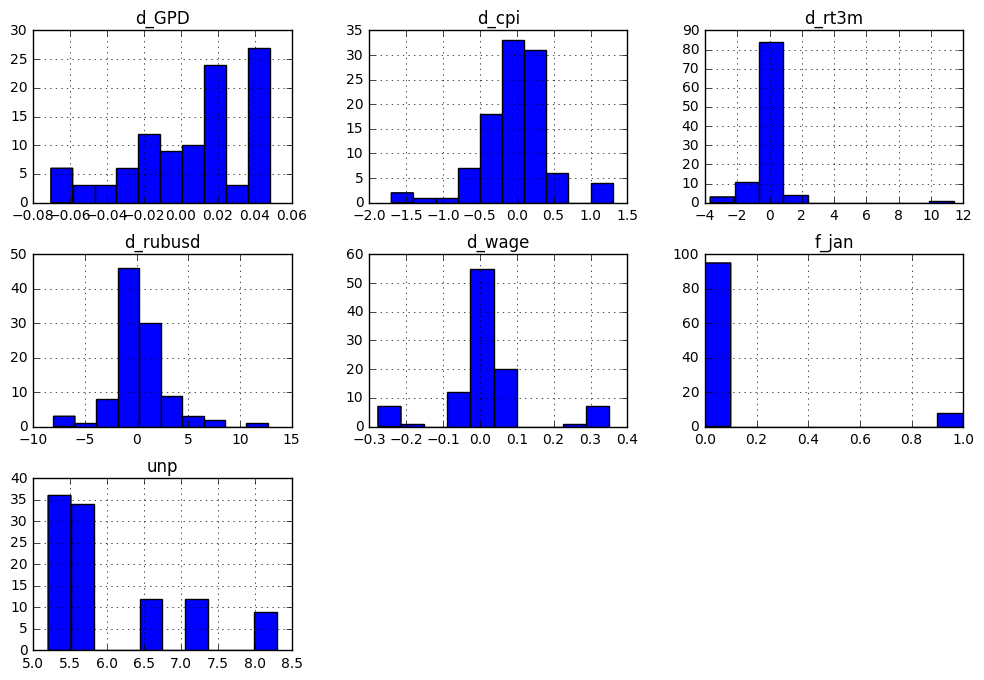

In [200]:
figsize(12, 8)
df[predictors].hist()

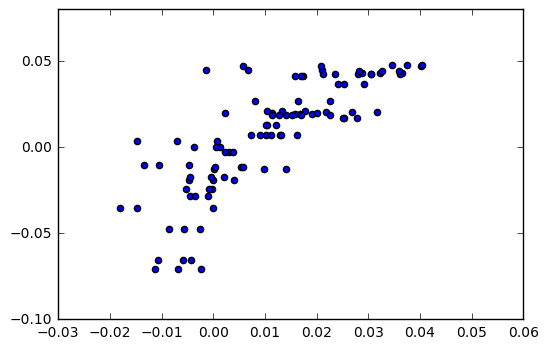

In [124]:
fig, ax = plt.subplots()
ax.scatter(df['portf_gr'], df['d_GPD'])

In [75]:
#Пока берем в качестве обучающей выборки всю выборку
#X_train = df[predictors]
#y_train = df['portf_gr']

#X_test = df[predictors].copy()
#y_test = df['portf_gr'].copy()

Смотрим на корреляции признаков

In [76]:
corr = df[predictors].corr()
corr

,d_wage,d_GPD,d_cpi,d_rt3m,f_jan,d_rubusd,f_dec,unp
d_wage,1.000000,0.000807,-0.119367,-0.174949,-0.675175,0.021355,0.734719,0.064783
d_GPD,0.000807,1.000000,0.024816,0.216277,0.016195,0.013677,-0.005812,-0.455573
d_cpi,-0.119367,0.024816,1.000000,0.426735,0.385821,0.090478,0.143649,-0.017277
d_rt3m,-0.174949,0.216277,0.426735,1.000000,0.314184,0.292862,0.061294,-0.194898
f_jan,-0.675175,0.016195,0.385821,0.314184,1.000000,0.088118,-0.084211,-0.068288
d_rubusd,0.021355,0.013677,0.090478,0.292862,0.088118,1.000000,0.162036,-0.104354
f_dec,0.734719,-0.005812,0.143649,0.061294,-0.084211,0.162036,1.000000,0.038185
unp,0.064783,-0.455573,-0.017277,-0.194898,-0.068288,-0.104354,0.038185,1.000000


Разбиваем на обучающую и тестовую выборки

In [170]:
X_train,X_test,y_train,y_test =train_test_split(df[predictors],df['portf_gr'],random_state=42)

Случайный лес

In [171]:
forest = RandomForestRegressor(n_estimators=1000, max_depth = 5,
                                random_state=42).fit(X_train, y_train)

features = pd.DataFrame(forest.feature_importances_,
                        index=X_train.columns,columns=['Importance']).sort_values(['Importance'], 
                                                     ascending=False)
test_pred = forest.predict(X_test)
features

,Importance
d_GPD,0.774284
d_rt3m,0.098263
d_rubusd,0.066082
d_wage,0.024042
unp,0.022210
d_cpi,0.014642
f_jan,0.000478


In [172]:
forest.score(X_train, y_train)

0.96252867606861992

In [173]:
forest.score(X_test, y_test)

0.74992004013401437

In [174]:
print(mean_squared_error(forest.predict(X_train), y_train))
print(cross_val_score(forest, X_train, y_train, scoring='mean_squared_error'))
#print(abs(np.mean(cross_val_score(forest, X_train, y_train, scoring='mean_squared_error', n_jobs=-1))))

7.88229120887e-06
[ -4.13592834e-05  -4.94134528e-05  -5.33283650e-05]


Нормируем выборку

In [175]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [176]:
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_train_scaled.head()

,d_wage,d_GPD,d_cpi,d_rt3m,f_jan,d_rubusd,unp
0,-0.322325,0.438226,-0.073293,-0.128783,-0.290701,0.099993,1.314340
1,-0.133582,-0.500494,-0.308443,-0.770197,-0.290701,-2.397423,-0.508517
2,-0.391159,1.214001,0.632156,0.050813,-0.290701,-0.074697,-0.579416
3,-1.974085,-1.678741,2.748505,-0.224995,3.439961,0.313602,1.314340
4,0.110222,-0.723520,-0.308443,-0.019742,-0.290701,-2.942287,-0.540282


In [177]:
linregsc = LinearRegression(n_jobs=-1)
linreg = LinearRegression(n_jobs=-1)
linregsc.fit(X_train_scaled, y_train)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [178]:
print(mean_squared_error(linreg.predict(X_train_scaled), y_train))
#print(mean_squared_error(linreg.predict(X_train), y_train))
print(r2_score(y_train,linregsc.predict(X_train_scaled)))
print(r2_score(y_train,linreg.predict(X_train)))
print(r2_score(y_test,linregsc.predict(X_test_scaled)))

0.134158177303
0.698543388739
0.698543388739
0.592500792965


In [179]:
linreg_coef = pd.DataFrame(np.c_[linregsc.coef_, np.abs(linregsc.coef_)], index=df[predictors].columns, 
                           columns=['Coeff.', 'Coeff.abs'])
linreg_coef.sort_values(by='Coeff.abs', ascending=False)

,Coeff.,Coeff.abs
d_GPD,0.011928,0.011928
d_cpi,0.003370,0.003370
f_jan,-0.002646,0.002646
d_rubusd,0.001994,0.001994
unp,0.001500,0.001500
d_wage,-0.000905,0.000905
d_rt3m,-0.000157,0.000157


In [141]:
test_l_pred = linreg.predict(X_test)

In [142]:
test_l_pred_sc = linregsc.predict(X_test_scaled)

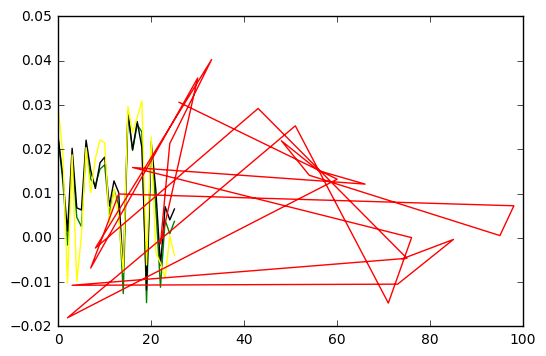

In [144]:
plt.plot(test_l_pred, label='linreg', c='green')
plt.plot(test_l_pred_sc, label='Scaled', c='black')
plt.plot(test_pred, label='forest', c='yellow')
plt.plot(y_test, label='Actual', c='red')
plt.show()    
    

In [180]:
lasso1 = Lasso(alpha=0.01, random_state=42)
#lasso1.fit(X_train_scaled, y_train)
lasso1.fit(X_train, y_train)
lasso1.coef_

array([ 0.,  0.,  0.,  0., -0.,  0., -0.])

In [181]:
lasso1_coef = pd.DataFrame(np.c_[lasso1.coef_, np.abs(lasso1.coef_)], index=df[predictors].columns, 
                           columns=['Coeff.', 'Coeff.abs'])
lasso1_coef.sort_values(by='Coeff.abs', ascending=False)

,Coeff.,Coeff.abs
d_wage,0.0,0.0
d_GPD,0.0,0.0
d_cpi,0.0,0.0
d_rt3m,0.0,0.0
f_jan,-0.0,0.0
d_rubusd,0.0,0.0
unp,-0.0,0.0


In [163]:
alphas = np.linspace(0.1, 10, 200)
lasso_cv = LassoCV(alphas=alphas, 
                   cv=5, random_state=7)
lasso_cv.fit(X_train_scaled, y_train)

LassoCV(alphas=array([  0.1    ,   0.14975, ...,   9.95025,  10.     ]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=7, selection='cyclic', tol=0.0001,
    verbose=False)

In [164]:
lasso_cv_coef = pd.DataFrame(np.c_[lasso_cv.coef_, np.abs(lasso_cv.coef_)], index=df[predictors].columns,  
                           columns=['Coeff.', 'Coeff.abs'])
lasso_cv_coef.sort_values(by='Coeff.abs', ascending=False)

,Coeff.,Coeff.abs
d_GPD,0.0,0.0
d_cpi,0.0,0.0
d_rt3m,0.0,0.0
f_jan,-0.0,0.0
d_rubusd,0.0,0.0
f_dec,-0.0,0.0
unp,-0.0,0.0


In [182]:
#print(mean_squared_error(lasso_cv.predict(X_train_scaled), y_train))
print(mean_squared_error(lasso_cv.predict(X_train), y_train))

0.000210355289909
